## Train Model

This notebook defines the model, trains it, and then evaluates it on the validation and test sets

Import libraries

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.regularizers import l2
from keras.layers import TimeDistributed, Bidirectional, BatchNormalization, Dropout, Input, Add, Masking
from keras import Model
import pdb
import pandas as pd
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
import glob
import sys
from sklearn.metrics import auc
import pickle

Using TensorFlow backend.


Define some constants related to the model

In [2]:
BATCH_SIZE = 64
INPUT_SEQ_LEN_MODEL1 = 10
INPUT_NUM_CH_MODEL1 = 5
INPUT_FEATS_MODEL2 = 33

Define a function to calculate the ROC

In [4]:
def roc(predictions, true, filename):
    predictions = predictions.flatten()
    true = true.flatten()

    thresh_vals = np.linspace(np.min(predictions), np.max(predictions), 50)
    results = []
    for thresh in thresh_vals:
        tmp_predictions = (predictions > thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(true, tmp_predictions).ravel()
        tpr = tp/(tp+fn)
        fpr = fp/(tn+fp)
        acc = (tp+tn)/(tn+fp+fn+tp)

        tmp_dict = {'acc': acc, 'tpr': tpr, 'fpr': fpr, 'thresh': thresh}
        results.append(tmp_dict)

    results = pd.DataFrame(results)
    results = results.sort_values(by='thresh', ascending=False)
    
    #calculate the AUC
    AUC = auc(results['fpr'].values, results['tpr'].values)

    plt.figure(figsize=(10,6))
    plt.plot(results['fpr'], results['tpr'], '*-')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC\nAUC=%.2f' % AUC)
    plt.tight_layout()
    plt.savefig('plots/ROC_%s.png' % filename, dpi=250)
    plt.show()

    results = results.sort_values(by='acc', ascending=False)
    final_thresh = results.head(1)['thresh'].values[0]

    return results, final_thresh


Load the data and set up the train, validation, and test sets

In [5]:
#load the training data
train = pd.read_pickle('train.pkl').reset_index(drop=True)

#define the validation set as 15% of the training set
N = len(train)
train = train.sample(frac=1).reset_index(drop=True)
val = train[:int(N*0.2)]
train = train[int(N*0.2):]

#separate out the training data
#note that input data for LSTM should be in the format of (number_samples, sequence_len, num_channels)
y_train = list(train['label'])
y_train = to_categorical(y_train)
X_train_cont = list(train['X_cont'].values)
X_train_cat = train.drop(['X_cont', 'label'], axis=1)

#for the mask layer, any NaN values need to be replaced by a unique value. use the constant np.pi
X_train_cat[X_train_cat.isna()] = np.pi
X_train_cat = list(X_train_cat.values)

#separate out the training data
y_val = list(val['label'])
y_val = to_categorical(y_val)
X_val_cont = list(val['X_cont'].values)
X_val_cat = val.drop(['X_cont', 'label'], axis=1)

#replace NaN with pi
X_val_cat[X_val_cat.isna()] = np.pi
X_val_cat = list(X_val_cat.values)

#load the test data
test = pd.read_pickle('test.pkl')
y_test = list(test['label'])
y_test = to_categorical(y_test)
X_test_cont = list(test['X_cont'].values)
X_test_cat = test.drop(['X_cont', 'label'], axis=1)

#replace NaN with pi
X_test_cat[X_test_cat.isna()] = np.pi
X_test_cat = list(X_test_cat.values)


Calculate the class weights

In [6]:
count_class_0 = np.sum(y_train[:,1].astype(int)==0)
count_class_1 = np.sum(y_train[:, 1].astype(int) == 1)
max_class_counts = np.max((count_class_0, count_class_1))
class_weights = {0: max_class_counts/count_class_0, 1: max_class_counts/count_class_1}
print('class weights -- no sepsis: {}, sepsis: {}'.format(class_weights[0], class_weights[1]))


class weights -- no sepsis: 1.0, sepsis: 54.361174458380844


Define the model using the functional API

In [7]:
input1 = Input(shape=(INPUT_SEQ_LEN_MODEL1, INPUT_NUM_CH_MODEL1))
model1 = Bidirectional(LSTM(100, kernel_regularizer=l2(0.001), return_sequences=True))(input1)
model1 = Bidirectional(LSTM(75, kernel_regularizer=l2(0.001)))(model1)
model1 = Dense(35, kernel_regularizer=l2(0.001), activation='relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dense(15, kernel_regularizer=l2(0.001), activation='relu')(model1)
model1 = BatchNormalization()(model1)

input2 = Input(shape=(INPUT_FEATS_MODEL2,))
model2 = Masking(mask_value=np.pi)(input2)
model2 = Dense(30, kernel_regularizer=l2(0.001), activation='relu')(model2)
model2 = BatchNormalization()(model2)
model2 = Dense(15, kernel_regularizer=l2(0.001), activation='relu')(model2)
model2 = BatchNormalization()(model2)

model_add = Add()([model1, model2])
output = Dense(2, kernel_regularizer=l2(0.001), activation='softmax')(model_add)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 5)        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 10, 200)      84800       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 150)          165600      bidirectional_1[0][0]            
____________________________________________________________________________________________

Train the model

In [8]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
history = model.fit([X_train_cont, X_train_cat],
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=50,
                    validation_data=([X_val_cont, X_val_cat], y_val),
                    callbacks=[earlystop, checkpoint],
                    class_weight=class_weights,
                    verbose=1)

#save the history
pickle.dump(history, open('history.pkl', 'wb'))

Train on 776828 samples, validate on 194206 samples
Epoch 1/50
776828/776828 [==============================] - 292s 375us/step - loss: 1.3216 - val_loss: 0.6175

Epoch 00001: val_loss improved from inf to 0.61751, saving model to model.h5
Epoch 2/50
776828/776828 [==============================] - 292s 376us/step - loss: 1.1951 - val_loss: 0.1373

Epoch 00002: val_loss improved from 0.61751 to 0.13727, saving model to model.h5
Epoch 3/50
776828/776828 [==============================] - 301s 388us/step - loss: 1.1605 - val_loss: 1.0921

Epoch 00003: val_loss did not improve from 0.13727
Epoch 4/50
776828/776828 [==============================] - 299s 384us/step - loss: 1.1537 - val_loss: 0.1961

Epoch 00004: val_loss did not improve from 0.13727
Epoch 5/50
776828/776828 [==============================] - 291s 375us/step - loss: 1.1670 - val_loss: 0.6232

Epoch 00005: val_loss did not improve from 0.13727
Epoch 6/50
776828/776828 [==============================] - 285s 367us/step - loss

Plot the training/validation loss

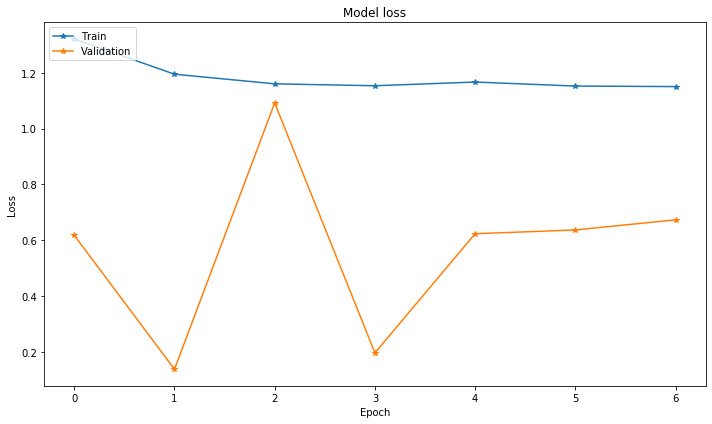

In [9]:
# Plot training & validation loss values
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], '*-')
plt.plot(history.history['val_loss'], '*-')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('plots/loss.png', dpi=250)
plt.show()
plt.close()


Evaluate the model on the validation set

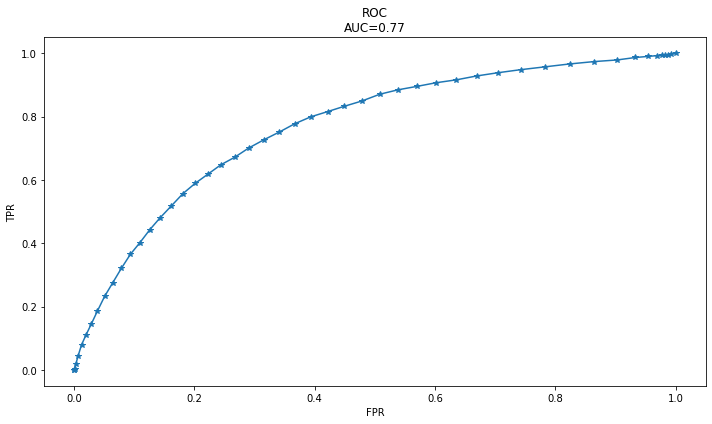

In [10]:
predictions = model.predict([X_val_cont, X_val_cat])

results_df, thresh_final = roc(predictions[:,1].flatten(), y_val[:,1].flatten(), 'val')
results_df = results_df.sort_values(by='fpr')


Evaluate the model on the test set

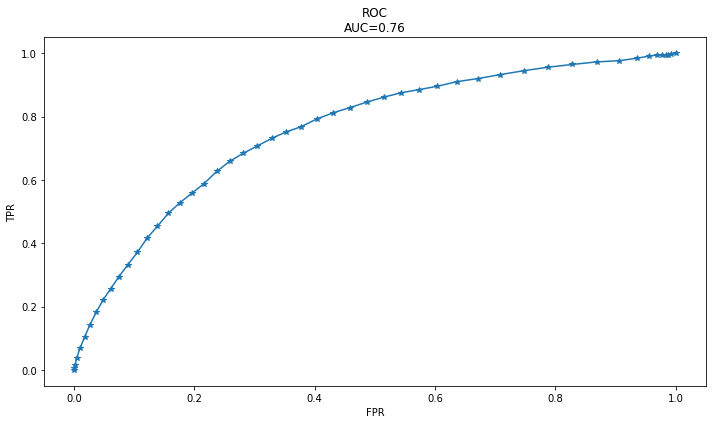

In [11]:
predictions = model.predict([X_test_cont, X_test_cat])

results_df, thresh_final = roc(predictions[:,1].flatten(), y_test[:,1].flatten(), 'test')
results_df = results_df.sort_values(by='fpr')
